### Speech Rate

There are many ways to calculate speech rate. Here I am examining speech rate as a continuous variable characterising either words or phrases. Do not mistake phrases for speech turns!

<ol>
    <li>
    <b>Phrases</b>
    <br>In spontaneous speech, tempo might change tremendously inside a speech turn. However, it usualy varies little inside phrases (e.g. noun phrases, verb phrases). For this reason I split turns into phrases.
    <br>I've broken down the ways of looking at speech rate into positive and negative ones:
    <ul>
        <li style="margin-bottom: 10px;">
        <i>Positive</i>: speech rate/tempo as number of elements in segment / segment duration. 
        <br> Naming reason: when comparing element duration against speech rate, I get negative correlations
        </li>
        <li>
        <i>Negative</i>: speech rate/tempo as segment duration/number of elements in segment. 
        <br>Naming reason: when comparing element duration against speech rate, I get positive correlations
        </li>
    </ul>
    </li>
    <p></p>
<li><b>Words</b> breaking speech turns down to words is another way of avoiding too much rate variation inside the analised segment. </li>
</ol>

Elements: <br>
In the case of phrases I took both syllable count and phoneme count, in the case of words, only phoneme count, as most of them are usually < 4 syllable long in my database.

I start with importing the needed modules:

In [1]:
# Here I import all python modules needed
import new_SR
import model_utilities
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from collections import defaultdict

Here I define my static data:

In [2]:
# Here you may point to the dataset you wish to analyse. Just replace the string with your absolute path
dp1 = model_utilities.get_path_list("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Rest")
dp2 = model_utilities.get_path_list("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/mod_dataset")
dataset_path = dp2 + dp1


# Path for saving pictures
fig_path = "C:/Users/alexutza_a/Abschlussarbeit/Grafiken/speech_rate/"
corr_file = "C:/Users/alexutza_a/Abschlussarbeit/Grafiken/speech_rate/SR_corr.txt"

# List of evaluated phonemes. 
# As there are also other phonetic items segmented in our database, we use this list to sort those out.
# Example of excluded phonetic items: <p:>, <usb>
valid_phonemes = ["a", "a~", "e", "E", "I", "i", "O", "o", "U", "u", "Y", "y", "9", "2", "a:", "a~:", "e:", "E:", "i:",
                 "o:", "u:", "y:", "2:", "OY", "aU", "aI", "@", "6", "z", "S", "Z", "C", "x", "N", "Q", "b", "d", "f", 
                 "g", "h", "j", "k", "l", "m", "n", "p", "r", "s", "t", "v"]

# A dictionary of classes of phonemes to use later
ptype_dict = {"diphthong" : ["aU", "aI", "OY"], "long_vowels" : ["a:", "a~:", "e:", "E:", "i:", "o:", "u:", "y:", "2:"],
              "short_vowels" : ["a", "a~", "e", "E", "I", "i", "O", "o", "U", "u", "Y", "y", "9", "2"], "schwa" : ["@", "6"],
              "plosive" : ["b", "d", "p", "t", "k", "g"], "fricative" : ["f", "v", "s", "S", "z", "Z", "x", "h", "C"],
              "nasal" : ["m", "n", "N"], "lateral" : ["l"], "approximant" : ["j"], "other" : [ "Q", "r"]}

# A list of definitions for SR used
SR_namelist = ["(phrase_dur/phon_count): ", "(phrase_dur/syl_count): ", "(phon_count/phrase_dur): ", 
           "(syl_count/phrase_dur): ", "(word_duration/phon_count): ", "(phon_count/word_duration): "]

The following dictionary contains rather few features, as it is only meant for the above specified purpose.

In [3]:
# Create a dictionary of phoneme durations and speech rates
# @param dataset_path: a list of links to the files in selected dataset
# Looks like: {"short_vowels" : [dur1, p_phon_PSR1, p_syl_PSR1, n_phon_PSR1, n_syl_PSR1, p_phon_WSR1, n_phon_WSR1], 
#               "diphthongs" : [...], ...} 
def SR_dict(dataset_path):
    sr_d = defaultdict(list)
    for datei in dataset_path:
        work_file = open(datei)
        for line in work_file:
            if re.match("MAU", line) and str(line.split()[4]) in valid_phonemes:
                # Get the corresponding class of the current phoneme
                phon_type = [ key for key, value in ptype_dict.items() if str(line.split()[4]) in value][0]
                #print(str(datei)[-22:] + str(line.split()[3]) + str(line.split()[4]))
                # Append phoneme duration in msec to the corresponding class in dict
                sr_d[phon_type].append(round(int(line.split()[2]) * 0.0625, 2))
                
                # Get the corresponding phrase no. for current phoneme
                phrase_dict = new_SR.s_split_dict(new_SR.get_split_list(datei))
                #print(phrase_dict)
                if len(phrase_dict) > 0:
                    phrase_nr = [key for key,value in phrase_dict.items() if int(line.split()[3]) in value][0]
                else:
                    phrase_nr = 0

                # Calculate the corresponding speech rates for current phoneme
                p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR = new_SR.get_phrase_SR(datei, phrase_nr, phrase_dict)
                p_phon_WSR, n_phon_WSR = new_SR.get_word_SR(datei, int(line.split()[3]))
                
                # Append all above speech rates to the dict              
                sr_d[phon_type] += [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]
        work_file.close()
    return sr_d

In [108]:
# Calculate dictionary once, use it then many times ;)
%time speechrate_d = SR_dict(dataset_path)

Wall time: 50min 55s


In [109]:
# Get the lists for plotting
# @param my_dict: a dictionary, in this case the result of SR_dict(p)
# @param phon_class: a string = the class of phonemes for which you wish to generate the value lists (e.g. "diphthongs")
def list_generator(my_dict, phon_class):
    duration_list = my_dict[phon_class][::7]
    p_phon_PSR = my_dict[phon_class][1::7]
    p_syl_PSR = my_dict[phon_class][2::7]
    n_phon_PSR = my_dict[phon_class][3::7]
    n_syl_PSR = my_dict[phon_class][4::7]
    p_phon_WSR = my_dict[phon_class][5::7]
    n_phon_WSR = my_dict[phon_class][6::7]
    return duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR

##### Now we start plotting

1. Long vowels

262878
262587


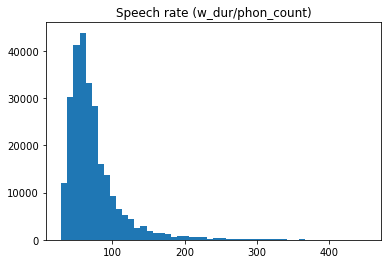

In [6]:
# Get all p_phon_WSR in one list together, to plot a histogram
SR_overview = []
for phon in speechrate_d.keys():
    SR_overview += speechrate_d[phon][5::7]
print(len(SR_overview))
SR_overview = [x for x in SR_overview if x < 450]
print(len(SR_overview))
#SR_overview = [ np.log(x) for x in SR_overview]
# Plot histogram of speech rate (word_duration / nr. of phonemes)
plt.hist(SR_overview, bins = 50)
plt.title("Speech rate (w_dur/phon_count)")
plt.show()

SR distribution when removing only 0.1% percent of the upper values.

In [144]:
def turn_rel(dataset_path):
    SR_list, SRi_list, p_dur_list, pi_dur_list = [], [], [], []
    for datei in dataset_path:
        work_file = open(datei)
        td = 0
        count_v, count_p = 0, 0
        tpd = []
        spd, spdi = [], []
        for line in work_file:
            if re.match("MAU", line) and (str(line.split()[4]) in valid_phonemes):
                td += int(line.split()[3]) 
                count_p += 1
                if str(line.split()[4]) in ptype_dict["long_vowels"]:
                    tpd.append(int(line.split()[3]))
                    count_v += 1
        if count_p >0:
            spd = [round(td / count_p, 2)]*count_v
            SR_list += spd
            p_dur_list += tpd
            
        if td > 0:
            spdi = [round(count_p / td, 2)]*count_v
            SRi_list += spdi
            pi_dur_list += tpd
        work_file.close()
    return SR_list, SRi_list, p_dur_list, pi_dur_list

In [145]:
SR_tl, SRi_tl, pdur_tl, pi_dur_list = turn_rel(dataset_path)

In [146]:
SR_tl = [x * 0.0625 for x in SR_tl]
SRi_tl = [x * 0.0625 for x in SRi_tl]
pdur_tl = [x * .0625 for x in pdur_tl]
pi_dur_list = [x * .0625 for x in pi_dur_list]

Pearson correlation coefficient (rho)
Long vowel duration vs. SR (turn_dur / phon count) 0.727178570436
Long vowel duration vs. SR (phon count / turn_dur) -0.270392865503


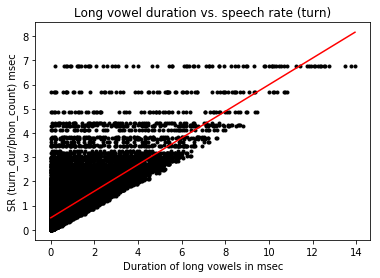

In [148]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
print("Long vowel duration vs. SR (turn_dur / phon count) " + str(pearsonr(pdur_tl, SR_tl)[0]))
print("Long vowel duration vs. SR (phon count / turn_dur) " + str(pearsonr(pi_dur_list, SRi_tl)[0]))
m, b = np.polyfit(pdur_tl, SR_tl,1) # elem. of the regression function
plt.scatter(pdur_tl, SR_tl, marker = ".", color = "k")
plt.plot((np.unique(pdur_tl)), (m*(np.unique(pdur_tl)) + b), "-", color="r") # plot regression line
plt.xlabel("Duration of long vowels in msec")
plt.ylabel("SR (turn_dur/phon_count) msec")
plt.title("Long vowel duration vs. speech rate (turn)")
    
plt.savefig(fig_path + "SR_turn.eps", format='eps', dpi=1200)

plt.show()

In [150]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "long_vowels")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Phoneme duration vs. SR (phrase_dur/phon_count): 0.561266362391
Phoneme duration vs. SR (phrase_dur/syl_count): 0.489500087602
Phoneme duration vs. SR (phon_count/phrase_dur): -0.377058296098
Phoneme duration vs. SR (syl_count/phrase_dur): -0.343874987183
Phoneme duration vs. SR (word_duration/phon_count): 0.794901825792
Phoneme duration vs. SR (phon_count/word_duration): -0.616539202577


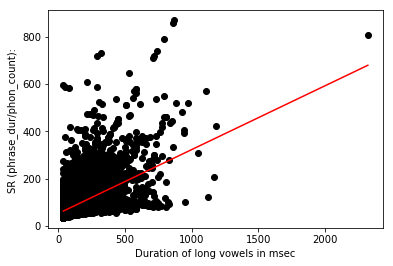

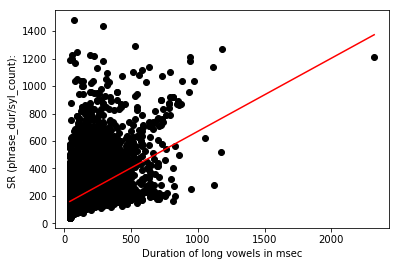

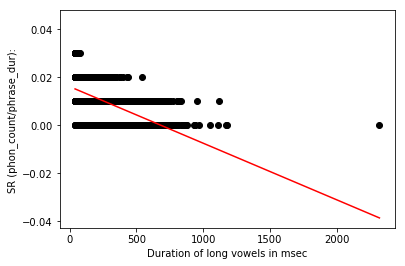

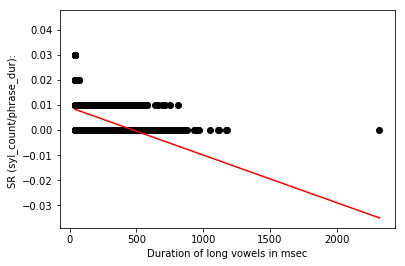

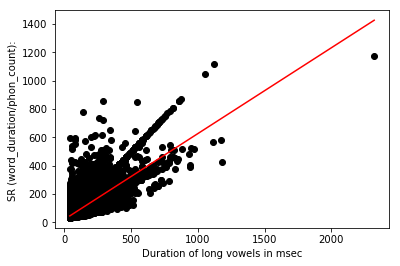

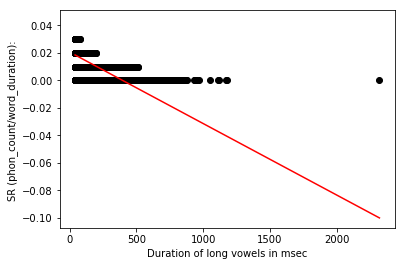

In [152]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Phoneme duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of long vowels in msec")
    plt.ylabel("SR " + SR_namelist[i])
    #plt.title("Long vowel duration vs. speech rate")
    
    plt.savefig(fig_path + "SR" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

2 Diphthongs

In [131]:
# Generate lists for category diphthongs
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "diphthong")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]
print(len(duration_list))

8495


Pearson correlation coefficient (rho)
Diphthong duration vs. SR (phrase_dur/phon_count): 0.397958684919
Diphthong duration vs. SR (phrase_dur/syl_count): 0.301203521632
Diphthong duration vs. SR (phon_count/phrase_dur): -0.284796047008
Diphthong duration vs. SR (syl_count/phrase_dur): -0.254422075744
Diphthong duration vs. SR (word_duration/phon_count): 0.698447543433
Diphthong duration vs. SR (phon_count/word_duration): -0.577731687411


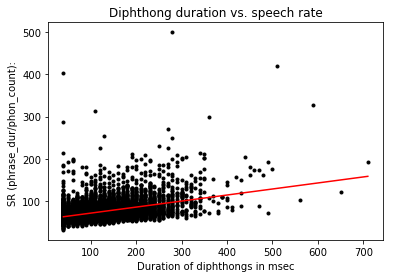

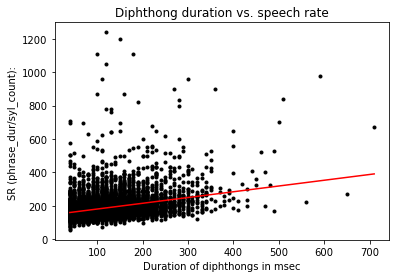

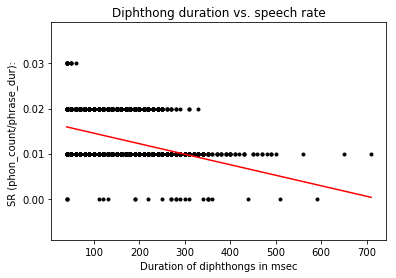

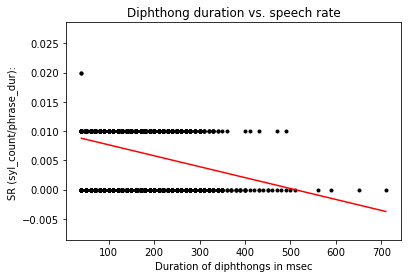

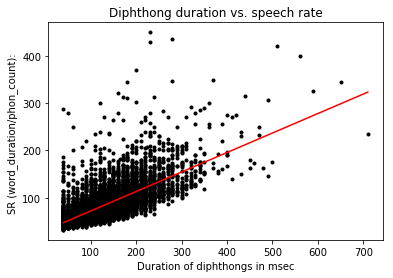

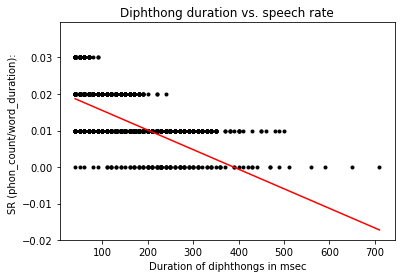

In [132]:
# First print the Pearson correlation coefficient for diphthongs and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Diphthong duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of diphthongs in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Diphthong duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_diph" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

3 Short vowels

In [11]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "diphthong")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Short vowel duration vs. SR (phrase_dur/phon_count): 0.477171428219
Short vowel duration vs. SR (phrase_dur/syl_count): 0.378519668709
Short vowel duration vs. SR (phon_count/phrase_dur): -0.392075534121
Short vowel duration vs. SR (syl_count/phrase_dur): -0.338224630418
Short vowel duration vs. SR (word_duration/phon_count): 0.628966406687
Short vowel duration vs. SR (phon_count/word_duration): -0.573261818977


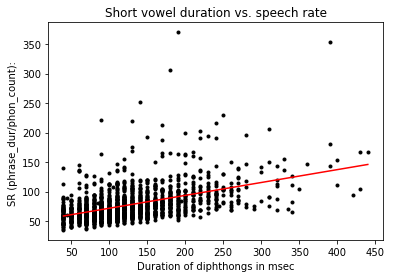

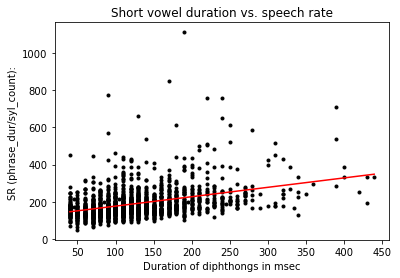

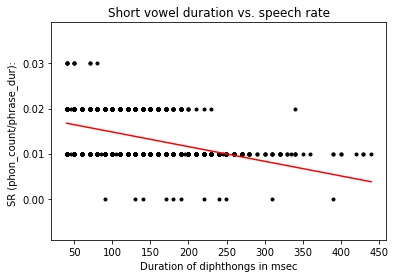

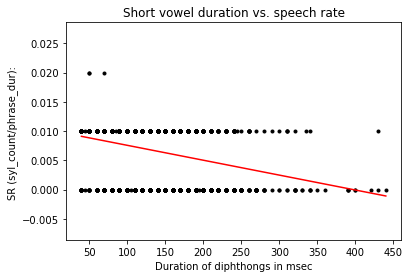

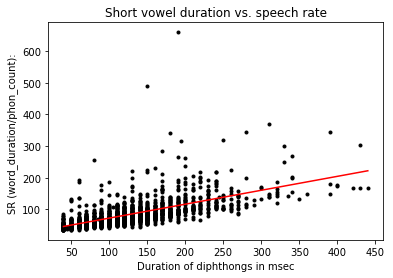

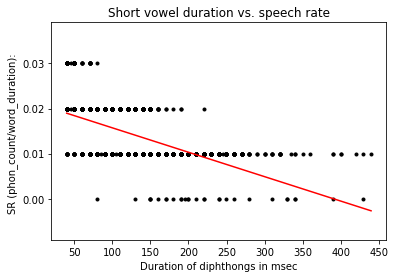

In [12]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Short vowel duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of diphthongs in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Short vowel duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_sv" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

4 Schwa

In [13]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "schwa")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Schwa duration vs. SR (phrase_dur/phon_count): 0.527519792601
Schwa duration vs. SR (phrase_dur/syl_count): 0.436260228617
Schwa duration vs. SR (phon_count/phrase_dur): -0.303545959834
Schwa duration vs. SR (syl_count/phrase_dur): -0.312339683773
Schwa duration vs. SR (word_duration/phon_count): 0.696649680918
Schwa duration vs. SR (phon_count/word_duration): -0.456600533309


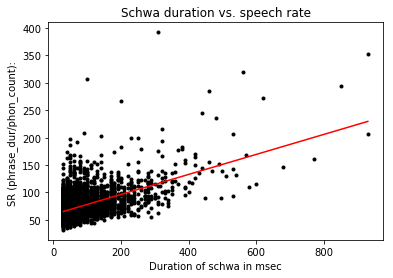

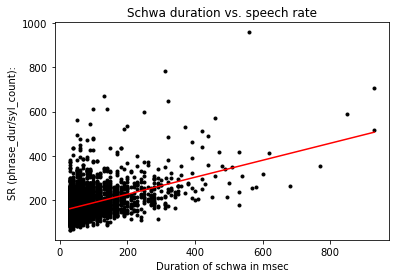

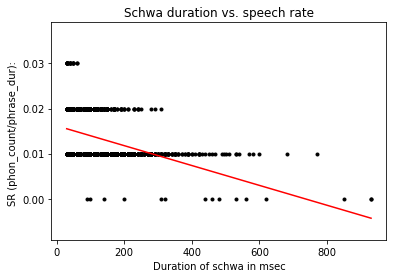

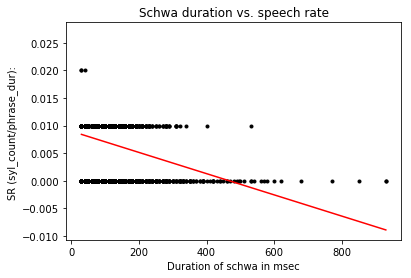

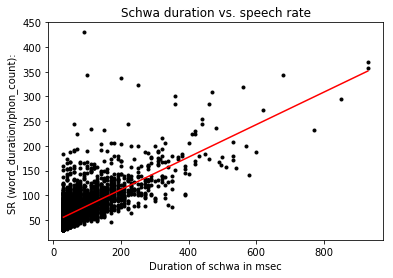

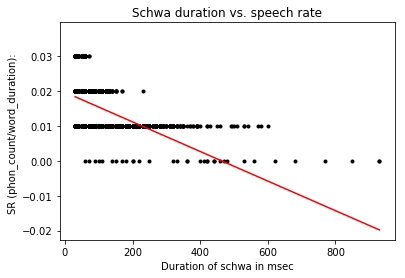

In [14]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Schwa duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of schwa in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Schwa duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_schwa" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

5 Plosives

In [15]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "plosive")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Plosive duration vs. SR (phrase_dur/phon_count): 0.513421863474
Plosive duration vs. SR (phrase_dur/syl_count): 0.503633037321
Plosive duration vs. SR (phon_count/phrase_dur): -0.244464766464
Plosive duration vs. SR (syl_count/phrase_dur): -0.201681959434
Plosive duration vs. SR (word_duration/phon_count): 0.606169575684
Plosive duration vs. SR (phon_count/word_duration): -0.317178308102


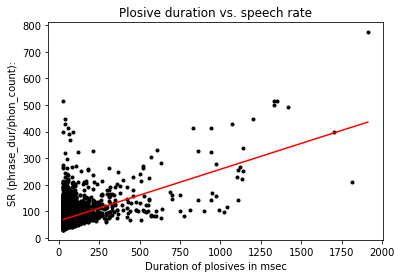

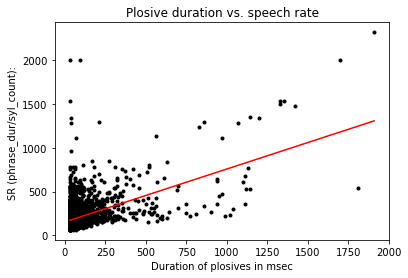

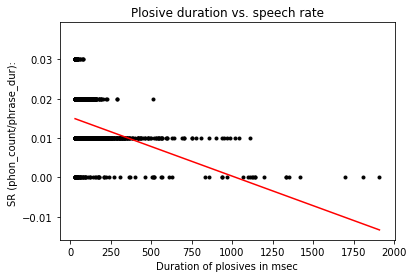

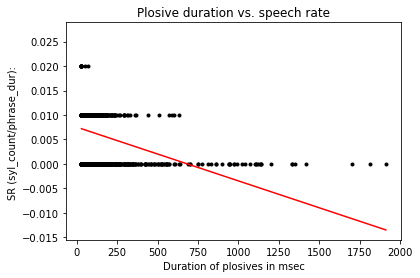

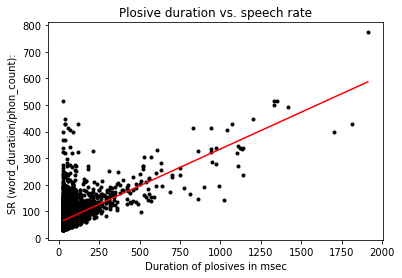

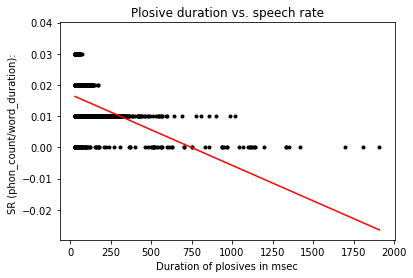

In [16]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Plosive duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of plosives in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Plosive duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_pl" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

6 Fricatives

In [17]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "fricative")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Fricative duration vs. SR (phrase_dur/phon_count): 0.435397023126
Fricative duration vs. SR (phrase_dur/syl_count): 0.400382189557
Fricative duration vs. SR (phon_count/phrase_dur): -0.272121279759
Fricative duration vs. SR (syl_count/phrase_dur): -0.257380665594
Fricative duration vs. SR (word_duration/phon_count): 0.64890627482
Fricative duration vs. SR (phon_count/word_duration): -0.411146840196


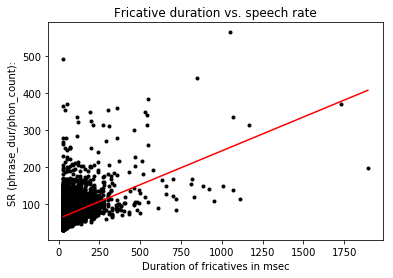

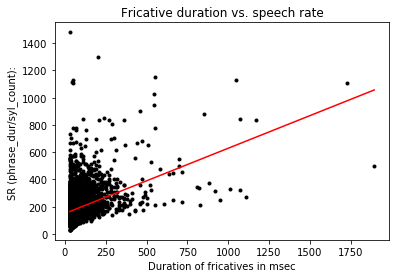

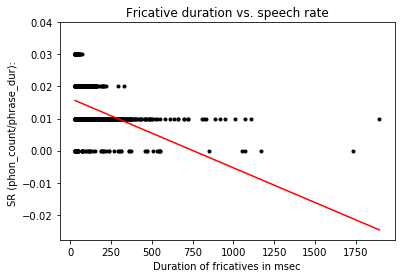

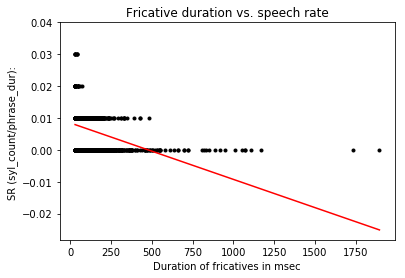

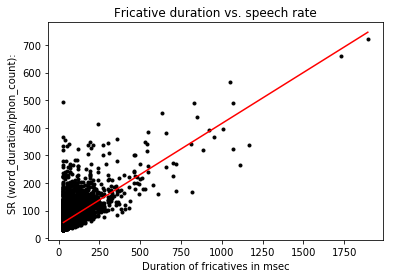

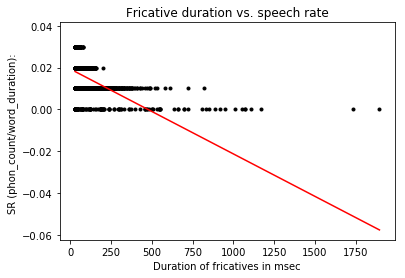

In [18]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Fricative duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of fricatives in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Fricative duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_fr" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

7 Nasals

In [19]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "nasal")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Nasal duration vs. SR (phrase_dur/phon_count): 0.562318523535
Nasal duration vs. SR (phrase_dur/syl_count): 0.520942788082
Nasal duration vs. SR (phon_count/phrase_dur): -0.375055962623
Nasal duration vs. SR (syl_count/phrase_dur): -0.352150396286
Nasal duration vs. SR (word_duration/phon_count): 0.668121792321
Nasal duration vs. SR (phon_count/word_duration): -0.495938578653


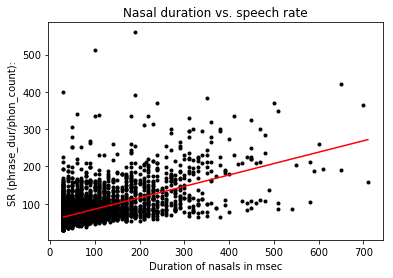

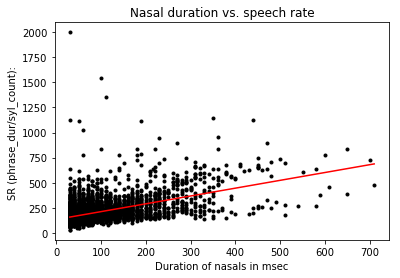

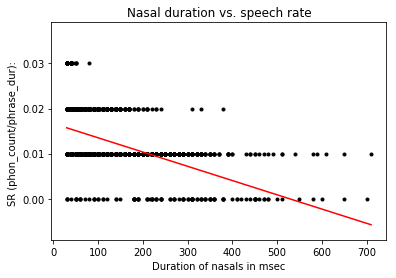

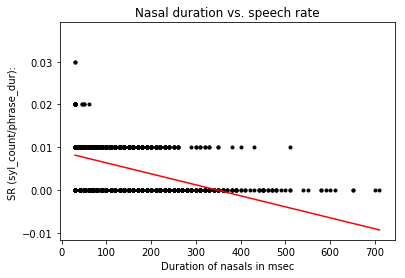

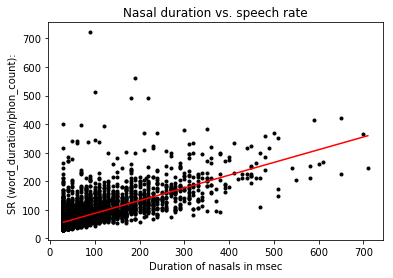

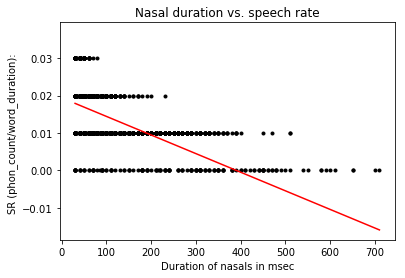

In [20]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Nasal duration vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of nasals in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Nasal duration vs. speech rate")
    
    plt.savefig(fig_path + "SR_n" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

8 Lateral: /l/

In [21]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "lateral")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /l/ vs. SR (phrase_dur/phon_count): 0.415978703787
Duration of /l/ vs. SR (phrase_dur/syl_count): 0.409427157403
Duration of /l/ vs. SR (phon_count/phrase_dur): -0.27596156158
Duration of /l/ vs. SR (syl_count/phrase_dur): -0.300514878507
Duration of /l/ vs. SR (word_duration/phon_count): 0.558501955064
Duration of /l/ vs. SR (phon_count/word_duration): -0.382170890561


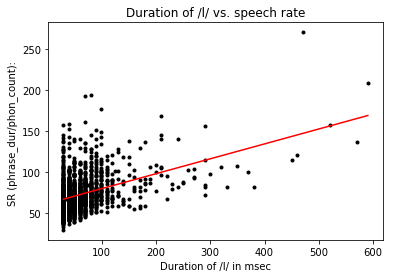

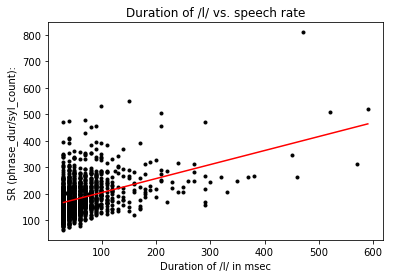

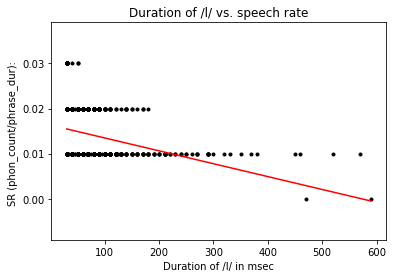

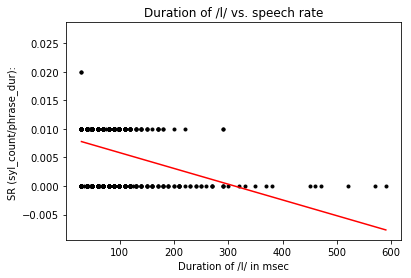

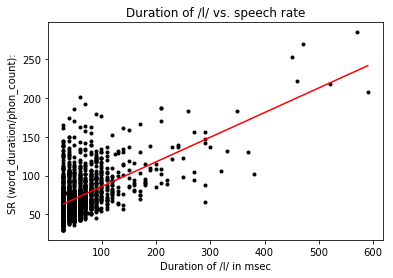

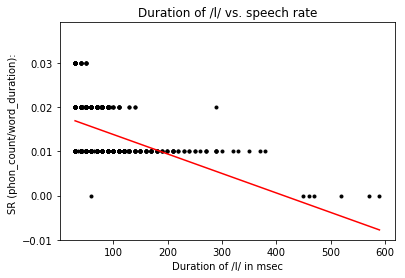

In [22]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /l/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /l/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /l/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_l" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

9 Approximant: /j/

In [23]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "approximant")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /j/ vs. SR (phrase_dur/phon_count): 0.56718620313
Duration of /j/ vs. SR (phrase_dur/syl_count): 0.471170832548
Duration of /j/ vs. SR (phon_count/phrase_dur): -0.509010093172
Duration of /j/ vs. SR (syl_count/phrase_dur): -0.385216432211
Duration of /j/ vs. SR (word_duration/phon_count): 0.625589904533
Duration of /j/ vs. SR (phon_count/word_duration): -0.527696992116


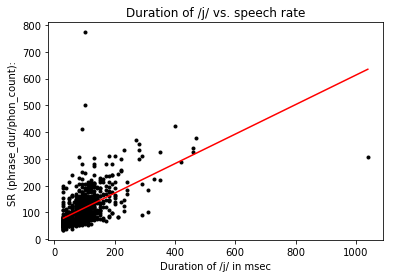

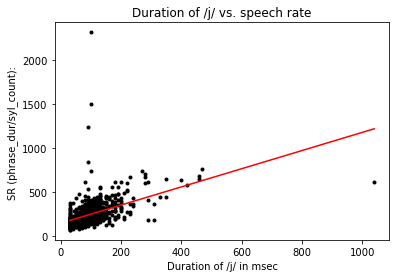

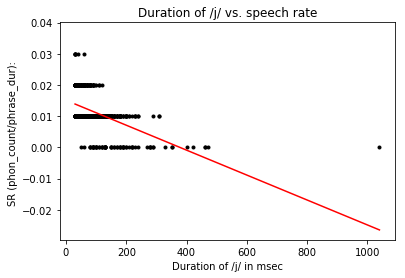

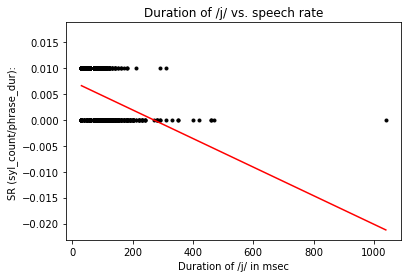

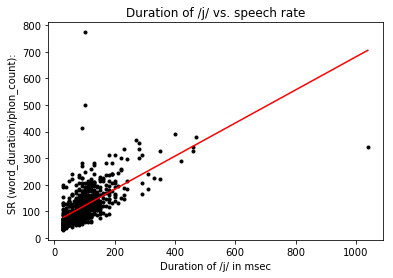

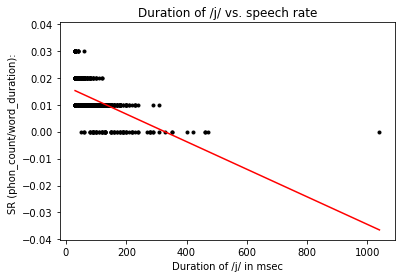

In [24]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /j/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /j/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /j/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_j" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

10 The extra shorts: /Q/ and /r/

In [25]:
# Generate lists for category long_vowels
duration_list, p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR = list_generator(speechrate_d, "other")
SR_list = [p_phon_PSR, p_syl_PSR, n_phon_PSR, n_syl_PSR, p_phon_WSR, n_phon_WSR]

Pearson correlation coefficient (rho)
Duration of /Q/ and /r/ vs. SR (phrase_dur/phon_count): 0.198563711602
Duration of /Q/ and /r/ vs. SR (phrase_dur/syl_count): 0.190914176646
Duration of /Q/ and /r/ vs. SR (phon_count/phrase_dur): -0.14659651476
Duration of /Q/ and /r/ vs. SR (syl_count/phrase_dur): -0.177263439243
Duration of /Q/ and /r/ vs. SR (word_duration/phon_count): 0.259545007528
Duration of /Q/ and /r/ vs. SR (phon_count/word_duration): -0.235035050159


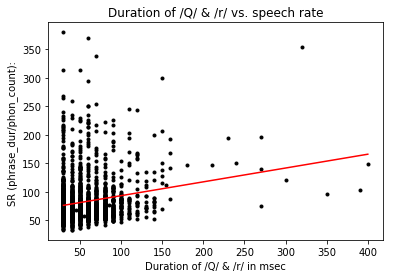

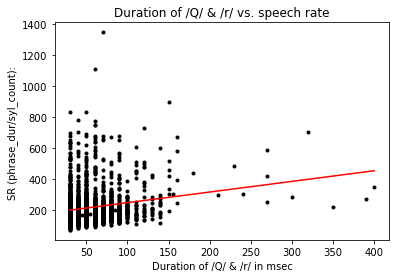

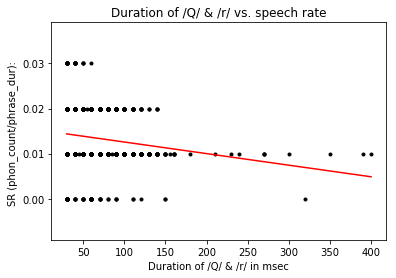

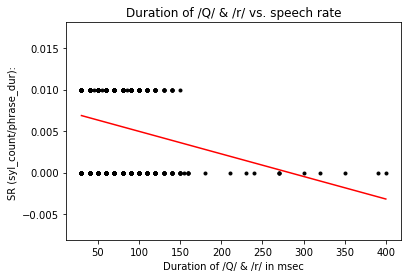

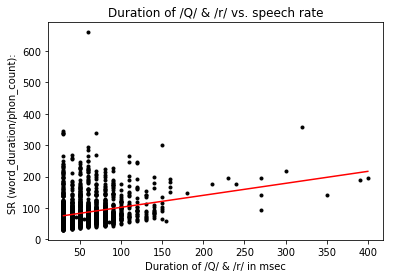

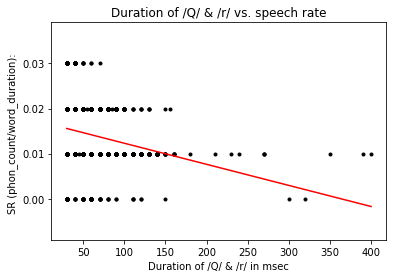

In [26]:
# First print the Pearson correlation coefficient for long_vowels and SR
print("Pearson correlation coefficient (rho)")
for i in range(len(SR_list)):
    print("Duration of /Q/ and /r/ vs. SR " + SR_namelist[i] + str(pearsonr(duration_list, SR_list[i])[0]))

# Now plot the data
for i in range(len(SR_list)):
    m, b = np.polyfit(duration_list, SR_list[i],1) # elem. of the regression function
    plt.scatter(duration_list, SR_list[i], marker = ".", color = "k")
    plt.plot((np.unique(duration_list)), (m*(np.unique(duration_list)) + b), "-", color="r") # plot regression line
    plt.xlabel("Duration of /Q/ & /r/ in msec")
    plt.ylabel("SR " + SR_namelist[i])
    plt.title("Duration of /Q/ & /r/ vs. speech rate")
    
    plt.savefig(fig_path + "SR_other" + str(i) + ".eps", format='eps', dpi=1200)

    plt.show()

In [106]:
import math

SR_list = []
for el in range(21):
    SR_list.append(new_SR.get_word_SR('C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/mod_dataset/g001acn1_022_AAJ_a.par', el)[0])
SR_list = [ (x/10)*2 for x in SR_list]
m = max(SR_list)
mi = min(SR_list)
num = int(m/mi)

points_per_w = [int(round((num / x)*10, 0)) for x in SR_list ]
print(points_per_w)
xs = []
i = 1
while i in range(21):
    xs += [round((float(i)-.5) +(math.pow(-1, el)*el)/(math.pow(el, 2)), 4) for el in range(points_per_w[i]+1) if el >1 ]
    if i >1:
        xs.append(float(i)-.5)
    i += 1
xs = [ x+1 for x in xs if x >=1]
xs += [0.1667, 0.5, 0.75, 1.0, 1.1667, 1.3, 1.3571, 1.5, 1.625, 1.6667, 1.75]
ys = [1]*len(xs)
print(sorted(xs))

[2, 4, 3, 2, 4, 2, 2, 4, 2, 5, 5, 4, 7, 5, 4, 3, 5, 2, 5, 3, 2]
[0.1667, 0.5, 0.75, 1.0, 1.1667, 1.3, 1.3571, 1.5, 1.625, 1.6667, 1.75, 2.0, 2.1667, 2.5, 3.0, 3.5, 4.0, 4.1667000000000005, 4.5, 4.75, 5.0, 5.5, 6.0, 6.5, 7.0, 7.1667, 7.5, 7.75, 8.0, 8.5, 9.0, 9.1667, 9.3, 9.5, 9.75, 10.0, 10.1667, 10.3, 10.5, 10.75, 11.0, 11.1667, 11.5, 11.75, 12.0, 12.1667, 12.3, 12.3571, 12.5, 12.6667, 12.75, 13.0, 13.1667, 13.3, 13.5, 13.75, 14.0, 14.1667, 14.5, 14.75, 15.0, 15.1667, 15.5, 16.0, 16.1667, 16.3, 16.5, 16.75, 17.0, 17.5, 18.0, 18.1667, 18.3, 18.5, 18.75, 19.0, 19.1667, 19.5, 20.0, 20.5, 21.0]


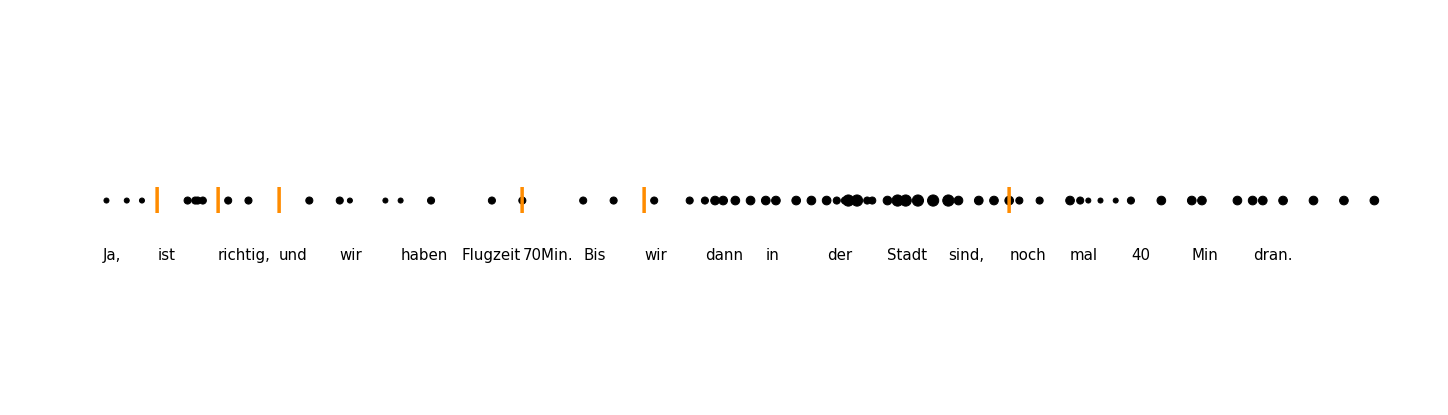

In [107]:
sli = []
for el in points_per_w:
    sli += [el]*el
sli = [ x-2 for x in sli if x <10]
sli = [ x * 25 for x in sli]

words = ["Ja,", "ist", "richtig,", "und", "wir", "haben", "Flugzeit", "70" "Min.", "Bis", "wir", "dann", "in", 
         "der", "Stadt", "sind,", "noch", "mal", "40", "Min", "dran."]
st_points = [.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
st = [ 1, 2,3,7,9,15,]

fig1 = plt.figure(figsize=(25, 7))
plt.scatter(xs, ys, s = sli, color = "k")
for i in range(len(words)):
    plt.annotate(words[i], xy=(st_points[i], 0.995), size = 15)
for j in range(len(st)):
    plt.text(st[j]-.09, .999, "I", size = 35, color = "darkorange")
plt.axis("off")
plt.savefig(fig_path + "SR_example.eps", format='eps', dpi=1200)
plt.show()